In [1]:
import xarray as xr
import pandas as pd
import os
import noaa_csl_funcs as ncf
import pyproj
import numpy as np
import xesmf as xe
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
base_data_storage_path = '/uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data' #where the data downloaded using data_download.py lives


## Testing

In [10]:
#Check that each day has only two nc files
for sector in listdir_visible(base_data_storage_path):
    # if not sector in ['area_onroad_diesel','area_onroad_gasoline','area_offroad','area_OG']:
    #     continue
    sector_path = os.path.join(base_data_storage_path,sector)
    for year in ['2019','2020','2021']:
        year_path = os.path.join(sector_path,year)
        for month in ['Month01','Month02','Month03','Month04','Month05','Month06','Month07','Month08','Month09','Month10','Month11','Month12']:
            month_path = os.path.join(year_path,month)
            for day_type in listdir_visible(month_path):
                if day_type not in ['satdy','sundy','weekdy']:
                    print(month_path,day_type)
                    continue
                day_path = os.path.join(month_path,day_type)
                files_list = os.listdir(day_path)
                num_files = len(files_list)
                if num_files != 2:
                    print(day_path)                    


/uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data/area_onroad_gasoline/2019/Month01 fuel_scalings.csv
/uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data/area_onroad_gasoline/2019/Month01 fuel_avg.nc
/uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data/area_onroad_gasoline/2019/Month02 fuel_scalings.csv
/uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data/area_onroad_gasoline/2019/Month02 fuel_avg.nc
/uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data/area_onroad_gasoline/2019/Month03 fuel_scalings.csv
/uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data/area_onroad_gasoline/2019/Month03 fuel_avg.nc
/uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data/area_onroad_gasoline/2019/Month04 fuel_scalings.csv
/uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data/area_onroad_gasoline/2019/Month04 fuel_avg.nc
/uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data/area_onroad_gasoline/2019/Month05 fuel_scalings.csv
/uufs/c

FileNotFoundError: [Errno 2] No such file or directory: '/uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data/area_onroad_gasoline/2020/Month01'

In [34]:
bau_or_covid = 'COVID'
full_sector = 'point_EGU'
year = 2019
month = 10
day_type = 'satdy'
hour_start = '12'

BCH = Base_CSL_Handler(base_data_storage_path,bau_or_covid)
#nc_fpath = BCH.get_full_fname(full_sector,year,month,day_type,'00')
#ds = xr.load_dataset(nc_fpath,chunks={'Time':1})

ds = BCH.load_fullday_nc(full_sector,year,month,day_type)

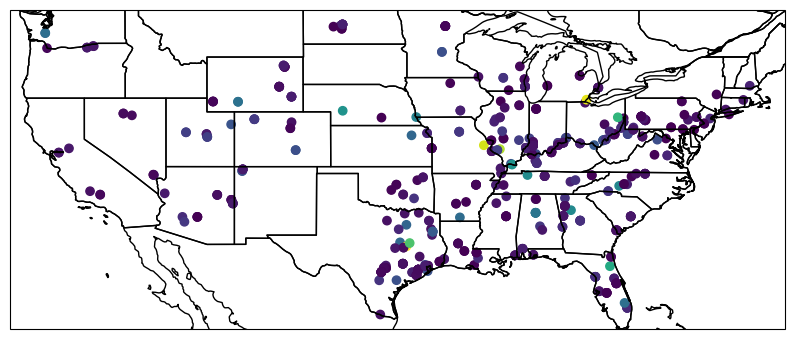

In [37]:
df = ds['CO2'][1].to_dataframe()
sub_df = df.loc[df['CO2']>100]

proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection = proj)
ax.scatter(sub_df['XLONG'],sub_df['XLAT'],c=sub_df['CO2'])
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
plt.show()

# Regridding

https://medium.com/pangeo/changing-the-way-you-look-at-earth-data-with-xesmf-ee55d0b380e5     
https://fabienmaussion.info/2018/01/06/wrf-projection/

In [3]:
bau_or_covid = 'COVID'
full_sector = 'area_Industry'
year = 2019
month = 1
day_type = 'weekdy'

BCH = ncf.Base_CSL_Handler(base_data_storage_path,bau_or_covid)
ds = BCH.load_fullday_nc(full_sector,year,month,day_type)#,chunks={'Time':1})
unit_converter = ncf.CSL_Unit_Converter()
ds_flx = unit_converter.absolute_to_flux(ds)
weights_path = '/uufs/chpc.utah.edu/common/home/u0890904/NOAA_CSL/noaa_csl/regridding/saved_weights'
inputs = ncf.RegridInputs
inputs.weights_path = weights_path
inputs.weights_file = '/uufs/chpc.utah.edu/common/home/u0890904/NOAA_CSL/noaa_csl/regridding/saved_weights/lcc_to_latlon_Industry_2020_1_weekdy.nc'
cr = ncf.CSL_Regridder(inputs)
regridded_ds = cr.regrid_ds(ds_flx)

#regridder = cr.create_regridder(ds_flx)
#regridder = cr.create_regridder(ds_flx,weightsfile_or_create='lcc_to_latlon_OG_2019_1_weekdy.nc')
#cr.save_regrid_weights(regridder)
#regridded_ds = regridder(ds_flx,keep_attrs=True)

og_ds = BCH.load_fullday_nc(full_sector,year,month,day_type)#,chunks={'Time':1})


Creating regridder
Regridding


## Sanity Checking

In [4]:
def sanity_check(og_ds,regridded_ds,regridded_ds_cellarea,species):
    '''A sanity check using daily sums of a single species to see if the total before and after regridding is close
    
    Args:
    og_ds (xr.Dataset) : the original dataset loaded from "base" noaa_csl data in LCC 
    regridded_ds (xr.Dataset) : the regridded dataset in WGS
    regridded_ds_cellarea (xr.Dataset) : a dataset with a cell_area data var giving the cell area in m2 for each cell in the regridded ds. from a loaded nc created by cdo gridarea 
    species (str) : the species to check
    
    Returns:
    perc_diff (float) : the difference (in percent) between the daily sum of all grid cells in the original versus the regridded dataset
    '''
    
    original_sum = float(og_ds[species].sum().values)
    regrid_daysum = regridded_ds[species].sum(dim='utc_hour')
    regrid_daysum_absolute = regrid_daysum * regridded_ds_cellarea['cell_area']
    regrid_sum = float(regrid_daysum_absolute.sum().values)
    perc_diff = abs(regrid_sum-original_sum)/((regrid_sum+original_sum)/2)*100
    print(f'{round(perc_diff,3)}% difference between base and regridded sums for {species}')
    return perc_diff

In [6]:
regridded_ds_cellarea = xr.open_dataset('./test/grid_out_area.nc')
sanity_check(og_ds,regridded_ds,regridded_ds_cellarea,'CO2')

0.132% difference between base and regridded sums for CO2


0.13212090950581493

### Grid area

In [37]:
sub_regridded_ds = regridded_ds['CO2'][1,:,:]
sub_regridded_ds.to_netcdf('./test/grid_out.nc')

Open a terminal in this subdir and run 'cdo gridarea ./test/grid_out.nc ./test/grid_out_area.nc'

In [42]:
grid_area = xr.open_dataset('./test/grid_out_area.nc')

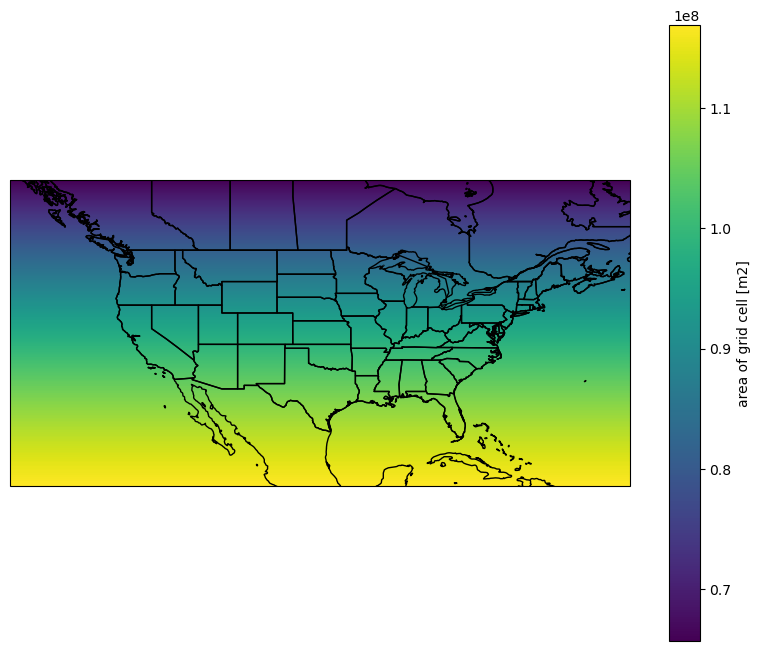

In [43]:
#Plot the grid cell area on a map -- should be less to the north and more to the south due to earth's shape
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection = proj)
grid_area['cell_area'].plot.pcolormesh('lon','lat',ax = ax,cmap = 'viridis')
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
plt.show()

## Unit conversion

In [11]:
class CSLSpeciesDetails:
    def __init__(self,csv_fullpath):
        self.csv_fullpath = csv_fullpath
        self.df = self.load_details_csv()

    def load_details_csv(self,csv_fullpath = None):
        if csv_fullpath is None:
            csv_fullpath = self.csv_fullpath
        
        species_details_df = pd.read_csv(csv_fullpath,header = 17)
        return species_details_df
    
    def make_mw_dict(self,saprc_version = 'either'):
        mw_dict = {}
        if saprc_version == 'either':
            for _,row in self.df.iterrows():
                species = row['NC_name']
                mw_dict[species] = {}
                if row['Known_MW'] == row['Known_MW']: #known mw is not a nan, so use this first
                    mw_dict[species]['mw(g/mol)']=row['Known_MW']
                    mw_dict[species]['mw_source'] ='Known_MW'
                elif row['SAPRC99_MW'] == row['SAPRC99_MW']: #use saprc99 first
                    mw_dict[species]['mw(g/mol)'] = row['SAPRC99_MW']
                    mw_dict[species]['mw_source'] = 'SAPRC99_MW'        
                elif row['SAPRC22_MW'] == row['SAPRC22_MW']: #use saprc22 next
                    mw_dict[species]['mw(g/mol)'] = row['SAPRC22_MW']
                    mw_dict[species]['mw_source'] = 'SAPRC22_MW'      
                else:
                    mw_dict[species]['mw(g/mol)'] = np.nan
                    mw_dict[species]['mw_source'] = np.nan   
        else:
            raise ValueError('Havent made anything other that "either"')  #could do SAPRC22 only, 99 only, mixed etc TODO
        return mw_dict
    
csd = CSLSpeciesDetails('/uufs/chpc.utah.edu/common/home/u0890904/NOAA_CSL/noaa_csl/NOAA_CSL_species.csv')
csl_mw_dict = csd.make_mw_dict()


In [13]:
regridded_ds[list(regridded_ds.data_vars.keys())[0]].attrs['units']

{'FieldType': 104,
 'MemoryOrder': 'XY ',
 'description': 'D4-Siloxane',
 'units': 'mole hr^-1 meters^-2',
 'stagger': '',
 'grid_mapping': 'latitude_longitude'}

In [22]:
for species in list(regridded_ds.data_vars.keys()):
    species_units_list = unit_converter.unit_finder(regridded_ds[species])
    if ('metric_Ton' in species_units_list) or ('metric_Ton(NO2equiv)' in species_units_list):
        print(species)



CO2
CO
NH3
NOX
PM10-PRI
PM25-PRI
SO2
VOC
PM01
PM02
PM03
PM04
PM05
PM06
PM07
PM08
PM09
PM10
PM11
PM12
PM13
PM14
PM15
PM16
PM17
PM18
PM19


['metric_Ton(NO2equiv)', 'hr^-1', 'meters^-2']

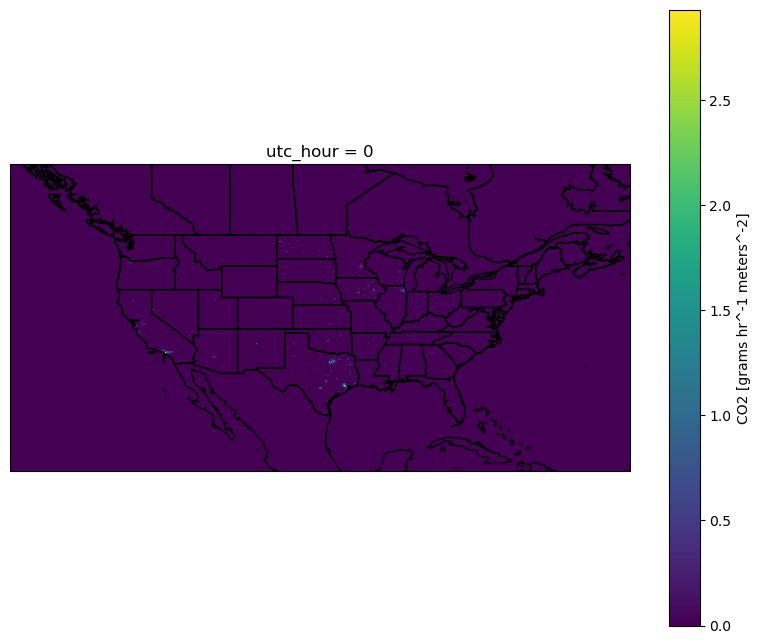

In [28]:
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection = proj)
#regridded_ds['CO2'][10,:,:].plot.pcolormesh('lon','lat',ax = ax,alpha=0.9,cmap='viridis')
regridded_ds_grams[0,:,:].plot.pcolormesh('lon','lat',ax = ax,cmap = 'viridis')
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
plt.show()